In [1]:
import dlib
import cv2
from skimage import io
import numpy as np
import matplotlib.pyplot as plt

# Facial Landmark detection

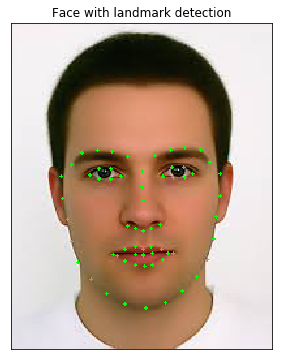

In [2]:
def get_facial_landmarks(predictor_path, image_path):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictor_path)
    image = io.imread(image_path)
    dets = detector(image, 1)
    #print("Number of faces detected: {}".format(len(dets)))
    for k, d in enumerate(dets):
        #print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(k, d.left(), d.top(), d.right(), d.bottom()))
        shape = predictor(image, d)       
    vec = np.empty([68, 2], dtype = int)
    for b in range(68):
        vec[b][0] = shape.part(b).x
        vec[b][1] = shape.part(b).y
    return vec

def show_facial_landmarks(landmarks, image_path):
    img = cv2.imread(image_path)
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    for landmark in landmarks:
        cv2.circle(image, (landmark[0], landmark[1]), 1, (0,255,0), -1)
    
    fig = plt.figure(figsize=(6, 6,))
    ax1 = fig.add_subplot(111)
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    ax1.set_title('Face with landmark detection')
    ax1.imshow(image)
    return None

image_path = './img/face.jpeg'
predictor_path = './../detector_architectures/shape_predictor_68_face_landmarks.dat'
landmarks = get_facial_landmarks(predictor_path, image_path)
show_facial_landmarks(landmarks, image_path)

# Convex hull

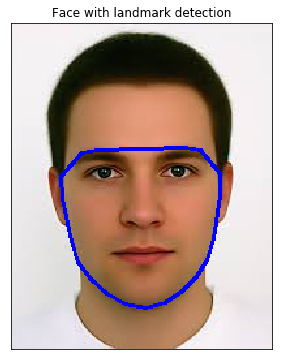

In [10]:
def get_convex_hull(points):
    return cv2.convexHull(points)
    
def draw_convex_hull(points, image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    filler = get_convex_hull(points)
    cv2.drawContours(img, [filler], -1, (0,0,255), 2)
    fig = plt.figure(figsize=(6, 6,))
    ax1 = fig.add_subplot(111)
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    ax1.set_title('Face with landmark detection')
    ax1.imshow(img)
    return None

draw_convex_hull(landmarks, image_path)